# Statistics Project #2 - Multivariate Analysis
***

## Introduction
***

**Description**: This script uses log2-FC protein expression (vs. Day 0) to determine which stages of infection cluster together based on ordination distances and principal component analysis. It also identifies which proteins are most responsible for the clustering (i.e. those that produce the most variation between stages). 

## Analysis
***

### Loads libraries, clears global environment, sets working directory, and sizes all plots

In [1]:
library(tidyverse)
library(readxl)
library(vegan)
library(ggtext)

rm(list = ls())

setwd('./')

options(repr.plot.width=6, repr.plot.height=4)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: permute
Loading required package: lattice
This is vegan 2.5-6


### Loads data, renames columns, and scales log2-FC protein values

In [2]:
file_name <- 'data/proteomics_TB_relative.xlsx'

proteins <- read_excel(file_name, sheet='Mtb relative', skip=1)

# does not include d00 since diffEXP of other timepoints calculated relative to d00
log2FC <- proteins[, c(1, 7:11)]

log2FC <- log2FC %>%
  dplyr::rename(Protein='Protein...1', d05='d05...7', d10='d10...8',
                d20='d20...9', d20.06='d20+06h...10', d20.48='d20+48h...11') %>%
  column_to_rownames(var = 'Protein')

# centers log2FC values (col value - col mean) and scales them (centered value / stnd. dev.)
log2FC_scaled <- as.data.frame(apply(log2FC, MARGIN = 2, FUN = scale),
                               row.names = rownames(log2FC))

log2FC_scaled

New names:
* Protein -> Protein...1
* Protein -> Protein...2
* d00 -> d00...6
* d05 -> d05...7
* d10 -> d10...8
* ...


,d05,d10,d20,d20.06,d20.48
Rv0001,-0.36509932,-0.617653835,-0.416322885,-0.391379910,-0.58078306
Rv0002,0.34052096,0.285545223,-0.160510036,0.035462157,0.55754124
Rv0005,0.03119920,-0.212113283,-0.363708806,-0.275038793,-0.26260650
Rv0006,-0.07271234,0.150662575,0.327648516,0.266037554,0.35830121
Rv0007,-0.53655784,-0.829949666,-0.827991048,-1.012709922,-0.52715210
Rv0008c,-0.05388936,0.066548444,0.003136684,-0.054598725,-0.46106162
Rv0009,-0.22441652,-0.006602043,0.182690545,0.002000166,-0.07279753
Rv0011c,-0.23617776,-0.202916439,-0.621482268,-0.537036051,-0.01468218
Rv0013,0.20382121,-0.041203820,-0.384507358,-0.361458103,0.26721063
Rv0014c,0.35807628,-0.090115969,0.235609688,0.345643271,0.03520898


### Which stages are most similar based on ordination distances?

In [3]:
# dataframe transposed so that stages (days) are rownames; required for ordination dist. calculation
protein_exp_euc <- vegdist(t(log2FC_scaled), method='euclidean')
protein_exp_euc  # most similar: d20, d20.06 // most different: d10, d20.48

protein_exp_man <- dist(t(log2FC_scaled), 'manhattan')
protein_exp_man  # most similar: d20, d20.06 // most different: d10, d20.48

            d05      d10      d20   d20.06
d10    20.77439                           
d20    27.40908 17.34927                  
d20.06 28.97234 21.62856 14.43795         
d20.48 35.03640 40.04867 39.48463 37.20989

             d05       d10       d20    d20.06
d10     693.1912                              
d20     893.7097  585.9764                    
d20.06  916.0753  679.9329  408.6911          
d20.48 1225.1742 1377.5890 1353.7687 1282.3634

**Analysis:** Euclidean and Manhattan distances converge on the same ordination result --> d20 and d20.06 are the most similar (i.e. their protein expressions are most correlated) whereas d10 and d20.48 are the most distinct.
- This clustering method examines all protein log2-FC's simultaneously to describe how each of the 5 stages differ.

### Plot: Principal Component Analysis
Can differentially expressed proteins (log2-FC vs. day 0) cluster to create distinct translational stages of infection? <br>
Let's see when principal component analysis (PCA) reduces the dimensionality to two.

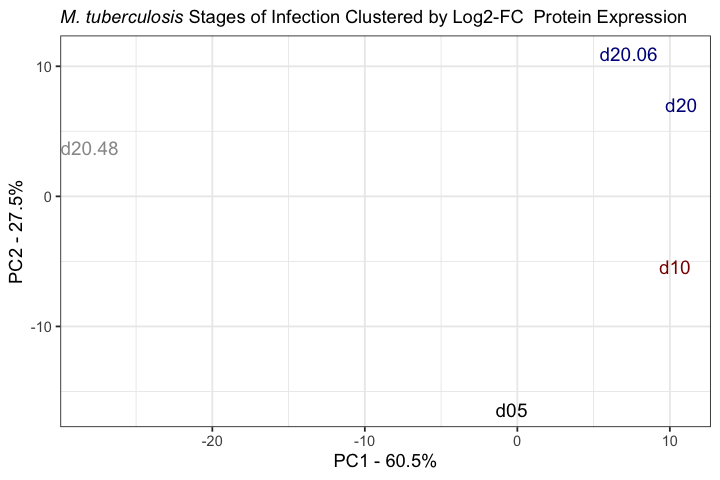

In [4]:
pca <- prcomp(t(log2FC_scaled), center=TRUE)  # already scaled; PCA via singular value decomposition of the matrix

## calculate the percentage of variation that each PC accounts for...
pca.var <- pca$sdev^2
pca.var.per <- round(pca.var/sum(pca.var)*100, 1)

pca.data <- data.frame(Sample=rownames(pca$x), X=pca$x[,1], Y=pca$x[,2])

pca_colors <- c('black', 'darkred', 'darkblue', 'darkblue', 'grey60')

subt <- '*M. tuberculosis* Stages of Infection Clustered by Log2-FC Protein Expression'

# we don't need summary() or plot() since info. captured in plot
ggplot(data=pca.data, aes(x=X, y=Y, label=Sample)) +
  geom_text(size=4, color=pca_colors) +
  xlab(paste('PC1 - ', pca.var.per[1], '%', sep='')) +
  ylab(paste('PC2 - ', pca.var.per[2], '%', sep='')) +
  labs(subtitle=subt) + theme_bw() + scale_color_manual(pca_colors) +
  theme(plot.subtitle=element_markdown(size=11))

**Analysis**: This seems clear-cut. The original paper referred to three stages of infection - normoxia (normal oxygen levels), hypoxia (low oxygen level), and reaeration (low to normal oxygen levels).

**Based on the PCA plot, I'd probably redefine these three stages as four stages - normoxia (d00, d05), early hypoxia (d10), late hypoxia (d20, d20.06), and reaeration (d20.48).**

### Identifies proteins most responsible for clustering based on loading scores
PCA is capable of distilling many proteins (indep. variables) down to a few key ones

In [5]:
loading_scores_pc1 <- pca$rotation[,1]  # all rows, PC1 col

protein_scores_pc1 <- abs(loading_scores_pc1)  # gets magnitudes

protein_score_ranked_pc1 <- sort(protein_scores_pc1, decreasing=TRUE)

top_six_proteins_pc1 <- names(protein_score_ranked_pc1[1:6])

pca$rotation[top_six_proteins_pc1,1] # shows their scores (and +/- sign)

Rv2826c     Rv1342c     Rv2771c      Rv0073      Rv1891     Rv1004c 
 0.20456662  0.15298443  0.11437454  0.10299631  0.10024237 -0.09611353

In [6]:
loading_scores_pc2 <- pca$rotation[,2]  # all rows, PC2 col

protein_scores_pc2 <- abs(loading_scores_pc2)  # gets magnitudes

protein_score_ranked_pc2 <- sort(protein_scores_pc2, decreasing=TRUE)

top_three_proteins_pc2 <- names(protein_score_ranked_pc2[1:3])

pca$rotation[top_three_proteins_pc2,1] # shows their scores (and +/- sign)

Rv0251c     Rv1984c     Rv2007c 
-0.08238120 -0.04526377  0.07065746

**'QC' of Results:** <br>
Rv2826c is one of the top 6 influential proteins for PC1 and it's log2-FC values vary among the 5 stages (Rv2826c: -1.83, 0.89, 1.16, 0.99, -2.99) <br>

On the flip side, one less influential protein is Rv2031c. Although it has a high log2-FC value across all days, consistently high expression like this would not produce variance in the data (Rv2031c: 7.57, 8.16, 7.95, 7.82, 6.41) <br>

Surprisingly, all six influential proteins for PC1 are uncharacterized, meaning their exact function is unknown. However, the three influential proteins for PC2 have annotated functions. <br>
- Rv0251c: heat shock protein
- Rv1984c: carboxylesterase; hydrolyzes various esters, including pNP-hexanoate (C6) and pNP-octanoate (C8)
- Rv2007c: ferredoxin; iron-sulfur protein that transfers electrons in a wide variety of metabolic reactions

## Conclusion
***
**Ultimately, this PCA analysis has enabled data-driven classifications (stages of infection in this case) as well as identification of high variance proteins that may be of interest for future analysis.**

### Plot: PCA with most influential proteins

'nperm' >= set of all permutations: complete enumeration.
Set of permutations < 'minperm'. Generating entire set.
'nperm' >= set of all permutations: complete enumeration.
Set of permutations < 'minperm'. Generating entire set.


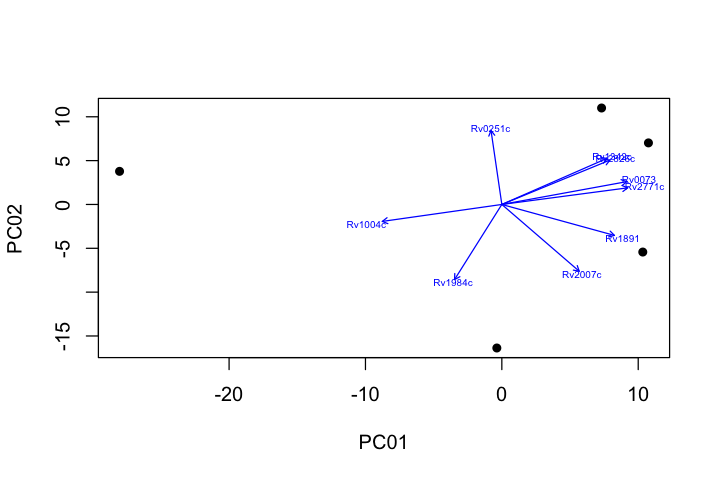

In [7]:
protein_most_var <- log2FC %>% rownames_to_column('Protein') %>%
  filter(Protein == 'Rv2826c' | Protein == 'Rv1342c' | Protein == 'Rv2771c' |
         Protein == 'Rv0073' | Protein == 'Rv1891' | Protein == 'Rv1004c' |
         Protein == 'Rv0251c' | Protein == 'Rv1984c' | Protein == 'Rv2007c') %>%
  column_to_rownames('Protein')

# calculates how site variables map onto the existing ordination
ef <- envfit(pca, t(protein_most_var))

plot(pca$x, xlab='PC01', ylab='PC02', pch=16, col='black')  # plots PCA data
plot(ef, cex=0.5)